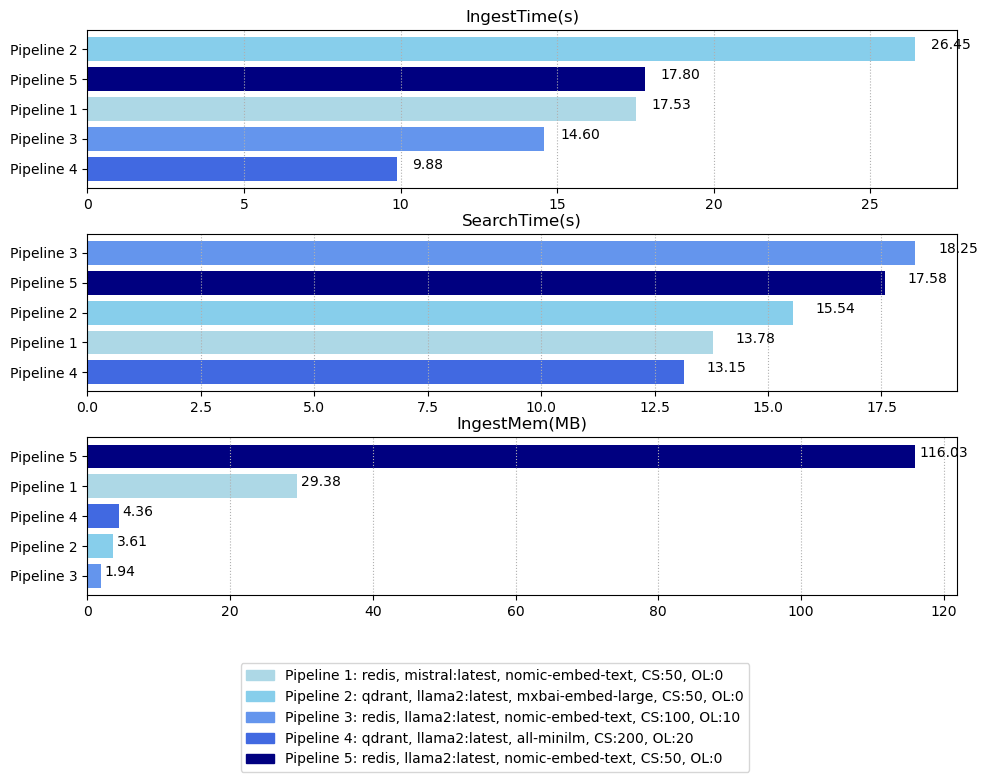

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

data = pd.read_csv('experiment_results.csv')

queries = data['Query'].unique()[:4]
data = data[data['Query'].isin(queries)]

data['Pipeline'] = data['VectorDB'] + "_" + data['LLM'] + "_" + data['EmbeddingModel'] + "_" + data['ChunkSize'].astype(str) + "_" + data['Overlap'].astype(str)

top_pipelines = [
    "redis_mistral:latest_nomic-embed-text_50_0",
    "qdrant_llama2:latest_mxbai-embed-large_50_0",
    "redis_llama2:latest_nomic-embed-text_100_10",
    "qdrant_llama2:latest_all-minilm_200_20",
    "redis_llama2:latest_nomic-embed-text_50_0"
]

pipeline_names = {}
for i, p in enumerate(top_pipelines):
    pipeline_names[p] = f"Pipeline {i+1}"
    
data['PipelineName'] = data['Pipeline'].map(lambda x: pipeline_names.get(x, "Other"))

metrics = ['IngestTime(s)', 'IngestMem(MB)', 'SearchTime(s)', 'SearchMem(MB)']
avg_data = data.groupby('Pipeline')[metrics].mean().reset_index()
avg_data['PipelineName'] = avg_data['Pipeline'].map(lambda x: pipeline_names.get(x, "Other"))
top_data = avg_data[avg_data['Pipeline'].isin(top_pipelines)]

pipeline_details = []
for i, pipeline in enumerate(top_pipelines):
    parts = pipeline.split('_')
    pipeline_details.append(f"Pipeline {i+1}: {parts[0]}, {parts[1]}, {parts[2]}, CS:{parts[3]}, OL:{parts[4]}")

colors = ['lightblue', 'skyblue', 'cornflowerblue', 'royalblue', 'navy']
color_map = {f"Pipeline {i+1}": colors[i] for i in range(5)}

plt.figure(figsize=(10, 8))

metrics_to_show = ['IngestTime(s)', 'SearchTime(s)', 'IngestMem(MB)']
for i, metric in enumerate(metrics_to_show):
    plt.subplot(3, 1, i+1)
    
    sorted_data = top_data.sort_values(by=metric)
    
    bars = plt.barh(sorted_data['PipelineName'], sorted_data[metric], 
                   color=[color_map[name] for name in sorted_data['PipelineName']])
    
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + 0.4, f'{width:.2f}')
    
    plt.title(metric)
    plt.grid(axis='x', linestyle=':')

legend_patches = []
for i, detail in enumerate(pipeline_details):
    legend_patches.append(Patch(color=colors[i], label=detail))

plt.figlegend(handles=legend_patches, loc='lower center', 
              bbox_to_anchor=(0.5, 0.02), ncol=1, frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()

<Figure size 1600x800 with 0 Axes>

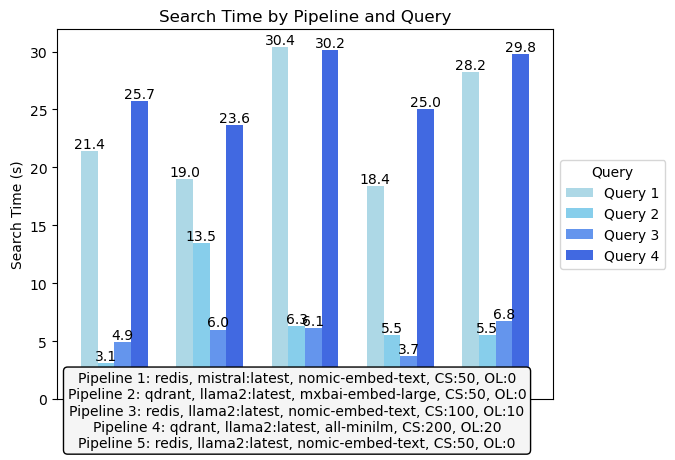

In [2]:
query_data = data.pivot_table(
    index='PipelineName', 
    columns='Query', 
    values='SearchTime(s)',
    aggfunc='mean'
)

query_data = query_data.loc[[f"Pipeline {i+1}" for i in range(5)]]
query_data.columns = [f'Query {i+1}' for i in range(len(query_data.columns))]

plt.figure(figsize=(16, 8))

bar_colors = [colors[i] for i in range(len(query_data.index))]
ax = query_data.plot(kind='bar', width=0.7, color=bar_colors)

plt.ylabel('Search Time (s)')
plt.title('Search Time by Pipeline and Query')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f')

plt.legend(title='Query', loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.figtext(0.5, 0.01, '\n'.join(pipeline_details), ha='center', 
            bbox=dict(facecolor='whitesmoke', boxstyle='round'))
plt.show()